In [73]:
import torch
import torch.nn as nn
import pandas as pd

In [74]:
class ParamMLP(nn.Module):
    def __init__(self, input_dim=2, hidden_dim=64, output_dim=6):
        super().__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.fc3 = nn.Linear(hidden_dim, hidden_dim)
        self.fc4 = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = torch.relu(self.fc3(x))
        x = self.fc4(x)
        return x

In [75]:
class RWGSModel(nn.Module):
    def __init__(self, fvst):
        super().__init__()
        self.fvst = fvst
        self.P = 1
        self.fi = self.P*self.fvst/1000/60/0.082057/298.15 # mol/s
        self.Ti = 200 # K
        self.L = 40 # cm
        self.z = torch.linspace(0, self.L, 201)
        self.CO2i = self.fi*0.24
        self.H2i = self.fi*0.72
        self.Ar = self.fi*0.04
        self.COi = self.fi*0
        self.H2Oi = self.fi*0
        self.CH4i = self.fi*0

    def forward(self, x):
        # inplace operation 제거
        x0 = 10**(1e-5*x[0])
        x1 = 10**(1e-5*x[1])
        x2 = 10**(1e-5*x[2])
        x3 = (1e-3*x[3])
        x4 = -10**(1e-3*x[4])
        x5 = 10**(x[5])+self.Ti
        CO2 = self.CO2i + 1e-5*(-x0 - x1 - x2)
        H2 = self.H2i + 1e-5*(-x0 - 4*x1 + 2*x2)
        CO = self.COi + 1e-5*(x0 + 2*x2)
        CH4 = self.CH4i + 1e-5*(x1 - x2)
        H2O = self.H2Oi + 1e-5*(x0 + 2*x1)
        Ar = self.Ar

        total = CO2 + H2 + CO + CH4 + H2O + Ar

        # 각 성분을 1차원 텐서로 변환 (201, 1)로 확장
        xCO2 = (CO2/total).unsqueeze(0)
        xH2 = (H2/total).unsqueeze(0)
        xCO = (CO/total).unsqueeze(0)
        xCH4 = (CH4/total).unsqueeze(0)
        xH2O = (H2O/total).unsqueeze(0)
        xAr = (Ar/total).unsqueeze(0)

        # 모든 성분을 (201, 1)로 확장 (z와 같은 길이로)
        xCO2 = xCO2.expand(self.z.shape[0], 1)
        xH2 = xH2.expand(self.z.shape[0], 1)
        xCO = xCO.expand(self.z.shape[0], 1)
        xCH4 = xCH4.expand(self.z.shape[0], 1)
        xH2O = xH2O.expand(self.z.shape[0], 1)
        xAr = xAr.expand(self.z.shape[0], 1)

        molf = torch.cat([xCO2, xH2, xAr, xCO, xCH4, xH2O], dim=1)  # (201, 6)
        
        T = x5 + x3*self.z + x4*self.z**2
        T = T.unsqueeze(1)  # (201, 1)

        return torch.cat([molf, T], dim=1)

In [76]:
class HybridModel(nn.Module):
    def __init__(self, fvst):
        super().__init__()
        self.param_mlp = ParamMLP(input_dim=2, hidden_dim=16, output_dim=6)
        self.rwgs_model = RWGSModel(fvst)
    
    def forward(self, flow_power):
        # ParamMLP로 5개 파라미터 예측
        params = self.param_mlp(flow_power)
        
        # RWGSModel로 조성 및 온도분포 계산
        output = self.rwgs_model(params)
        
        return output

In [77]:
import torch.optim as optim
import numpy as np

# 온도 측정 인덱스 (TI-1~TI-16)
temp_indices = np.array([10, 16, 24, 34, 45, 57, 71, 87, 113, 128, 142, 155, 166, 175, 183, 190])

def train_hybrid_model(model, data, epochs=10000, lr=0.001):
    optimizer = optim.Adam(model.parameters(), lr=lr)
    criterion = nn.MSELoss()
    
    losses = []
    
    for epoch in range(epochs):
        optimizer.zero_grad()
        
        total_loss = 0
        
        for i in range(len(data)):
            row = data.iloc[i]
            
            # 입력: Flow, Power
            flow_power = torch.tensor([row['Flow'], row['Power']], dtype=torch.float32)
            
            # 예측
            pred = model(flow_power)  # (201, 7)
            
            # 1. 출구 조성 손실 (마지막 지점, z=40cm)
            # 실험 데이터 조성 순서: CO2, H2, Ar, CO, CH4, H2O
            exp_composition = torch.tensor([
                row['CO2'], row['H2'], row['Ar'], row['CO'], row['CH4'], row['H2O']
            ], dtype=torch.float32)
            
            # 예측 조성 순서: CO2, H2, Ar, CO, CH4, H2O (이미 맞춤)
            pred_composition = pred[-1, :6]  # 처음 6개 성분
            
            composition_loss = criterion(pred_composition, exp_composition)
            
            # 2. 온도 프로파일 손실 (TI-1~TI-16)
            exp_temps = torch.tensor([
                row[f'TI-{i}'] for i in range(1, 17)
            ], dtype=torch.float32)
            
            pred_temps = pred[temp_indices, 6]  # 온도는 인덱스 6
            temp_loss = criterion(pred_temps, exp_temps)
            
            # 총 손실
            loss = composition_loss + temp_loss
            total_loss += loss
        
        total_loss.backward()
        optimizer.step()
        
        losses.append(total_loss.item())
        
        if epoch % 100 == 0:
            print(f'Epoch {epoch}, Loss: {total_loss.item():.6f}')
    
    return losses

# 전체 데이터 로드
df_full = pd.read_csv('data.csv')
print(f"전체 데이터 수: {len(df_full)}")

# 학습
fvst = df_full.iloc[0]['Flow']  # 첫 번째 데이터의 Flow로 초기화  
hybrid_model = HybridModel(fvst)

print("학습 시작...")
losses = train_hybrid_model(hybrid_model, df_full, epochs=100000, lr=0.001)

전체 데이터 수: 23
학습 시작...
Epoch 0, Loss: 19384202.000000
Epoch 100, Loss: 14532886.000000
Epoch 200, Loss: 12976511.000000
Epoch 300, Loss: 8376859.000000
Epoch 400, Loss: 6349647.500000
Epoch 500, Loss: 5590090.000000
Epoch 600, Loss: 4956233.000000
Epoch 700, Loss: 4423739.000000
Epoch 800, Loss: 3970790.250000
Epoch 900, Loss: 3579127.500000
Epoch 1000, Loss: 3234704.250000
Epoch 1100, Loss: 2912101.500000
Epoch 1200, Loss: 2630899.000000
Epoch 1300, Loss: 2375042.750000
Epoch 1400, Loss: 2144664.250000
Epoch 1500, Loss: 1922366.375000
Epoch 1600, Loss: 1718575.250000
Epoch 1700, Loss: 1533045.625000
Epoch 1800, Loss: 6187235.500000
Epoch 1900, Loss: 2706762.250000
Epoch 2000, Loss: 4298582.500000
Epoch 2100, Loss: 3664151.000000
Epoch 2200, Loss: 3208354.000000
Epoch 2300, Loss: 2880630.500000
Epoch 2400, Loss: 2614714.000000
Epoch 2500, Loss: 682120.937500
Epoch 2600, Loss: 2519633.000000
Epoch 2700, Loss: 2543319.250000
Epoch 2800, Loss: 2422288.000000
Epoch 2900, Loss: 2333692.25000


=== 모델 평가 결과 ===
Sample 1 - Composition MAE: 0.0077, Temperature MAE: 96.40 K
Sample 2 - Composition MAE: 0.0080, Temperature MAE: 93.44 K
Sample 3 - Composition MAE: 0.0081, Temperature MAE: 93.33 K
Sample 4 - Composition MAE: 0.0019, Temperature MAE: 72.58 K
Sample 5 - Composition MAE: 0.0018, Temperature MAE: 71.83 K
Sample 6 - Composition MAE: 0.0016, Temperature MAE: 71.55 K
Sample 7 - Composition MAE: 0.0063, Temperature MAE: 52.90 K
Sample 8 - Composition MAE: 0.0067, Temperature MAE: 51.74 K
Sample 9 - Composition MAE: 0.0066, Temperature MAE: 51.19 K
Sample 10 - Composition MAE: 0.0129, Temperature MAE: 35.69 K
Sample 11 - Composition MAE: 0.0142, Temperature MAE: 34.76 K
Sample 12 - Composition MAE: 0.0149, Temperature MAE: 34.91 K
Sample 13 - Composition MAE: 0.0068, Temperature MAE: 67.99 K
Sample 14 - Composition MAE: 0.0070, Temperature MAE: 66.39 K
Sample 15 - Composition MAE: 0.0008, Temperature MAE: 64.46 K
Sample 16 - Composition MAE: 0.0004, Temperature MAE: 63.78 K

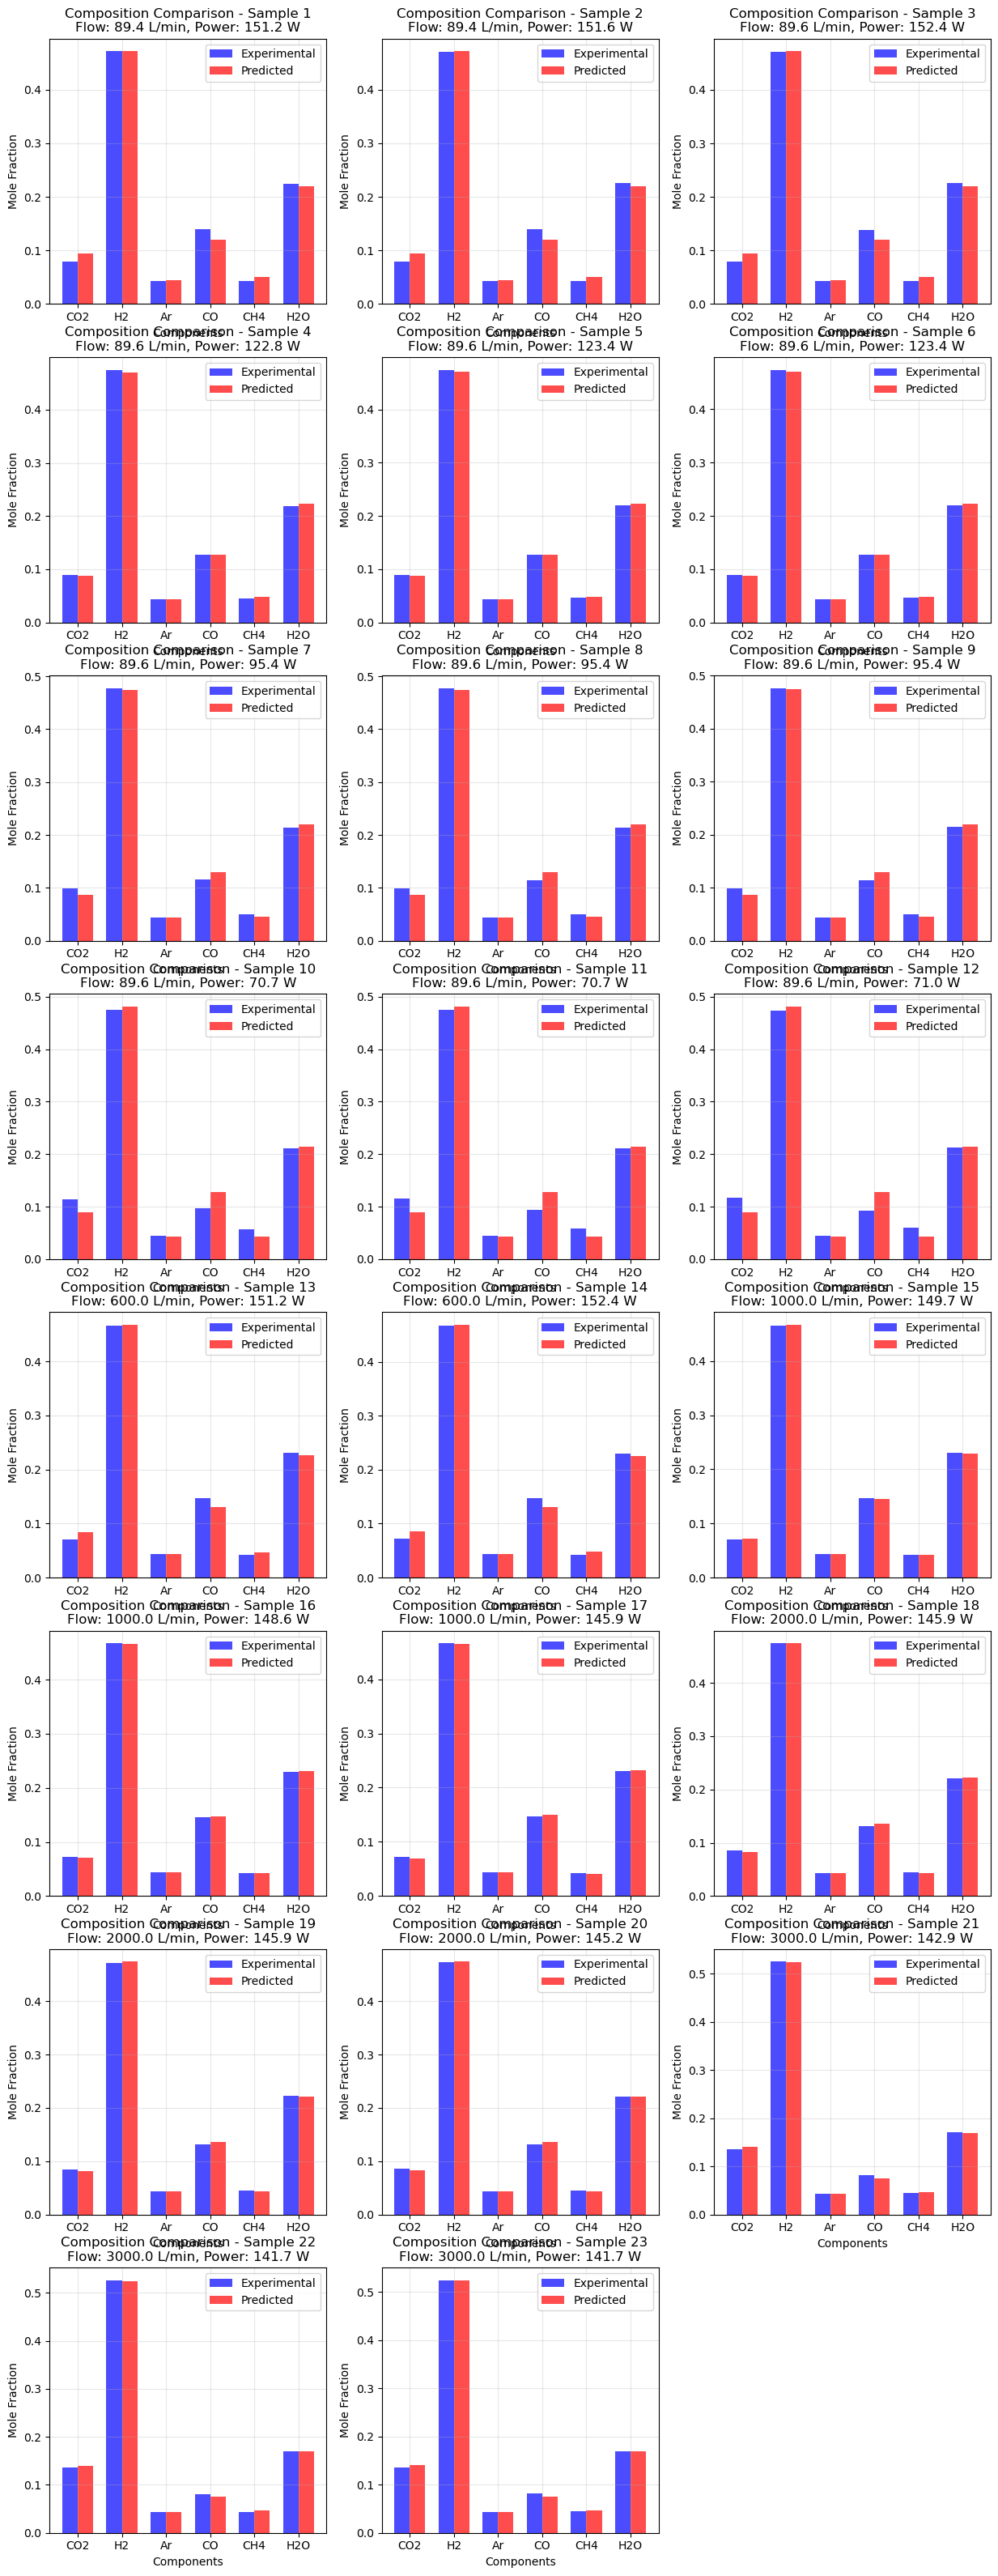

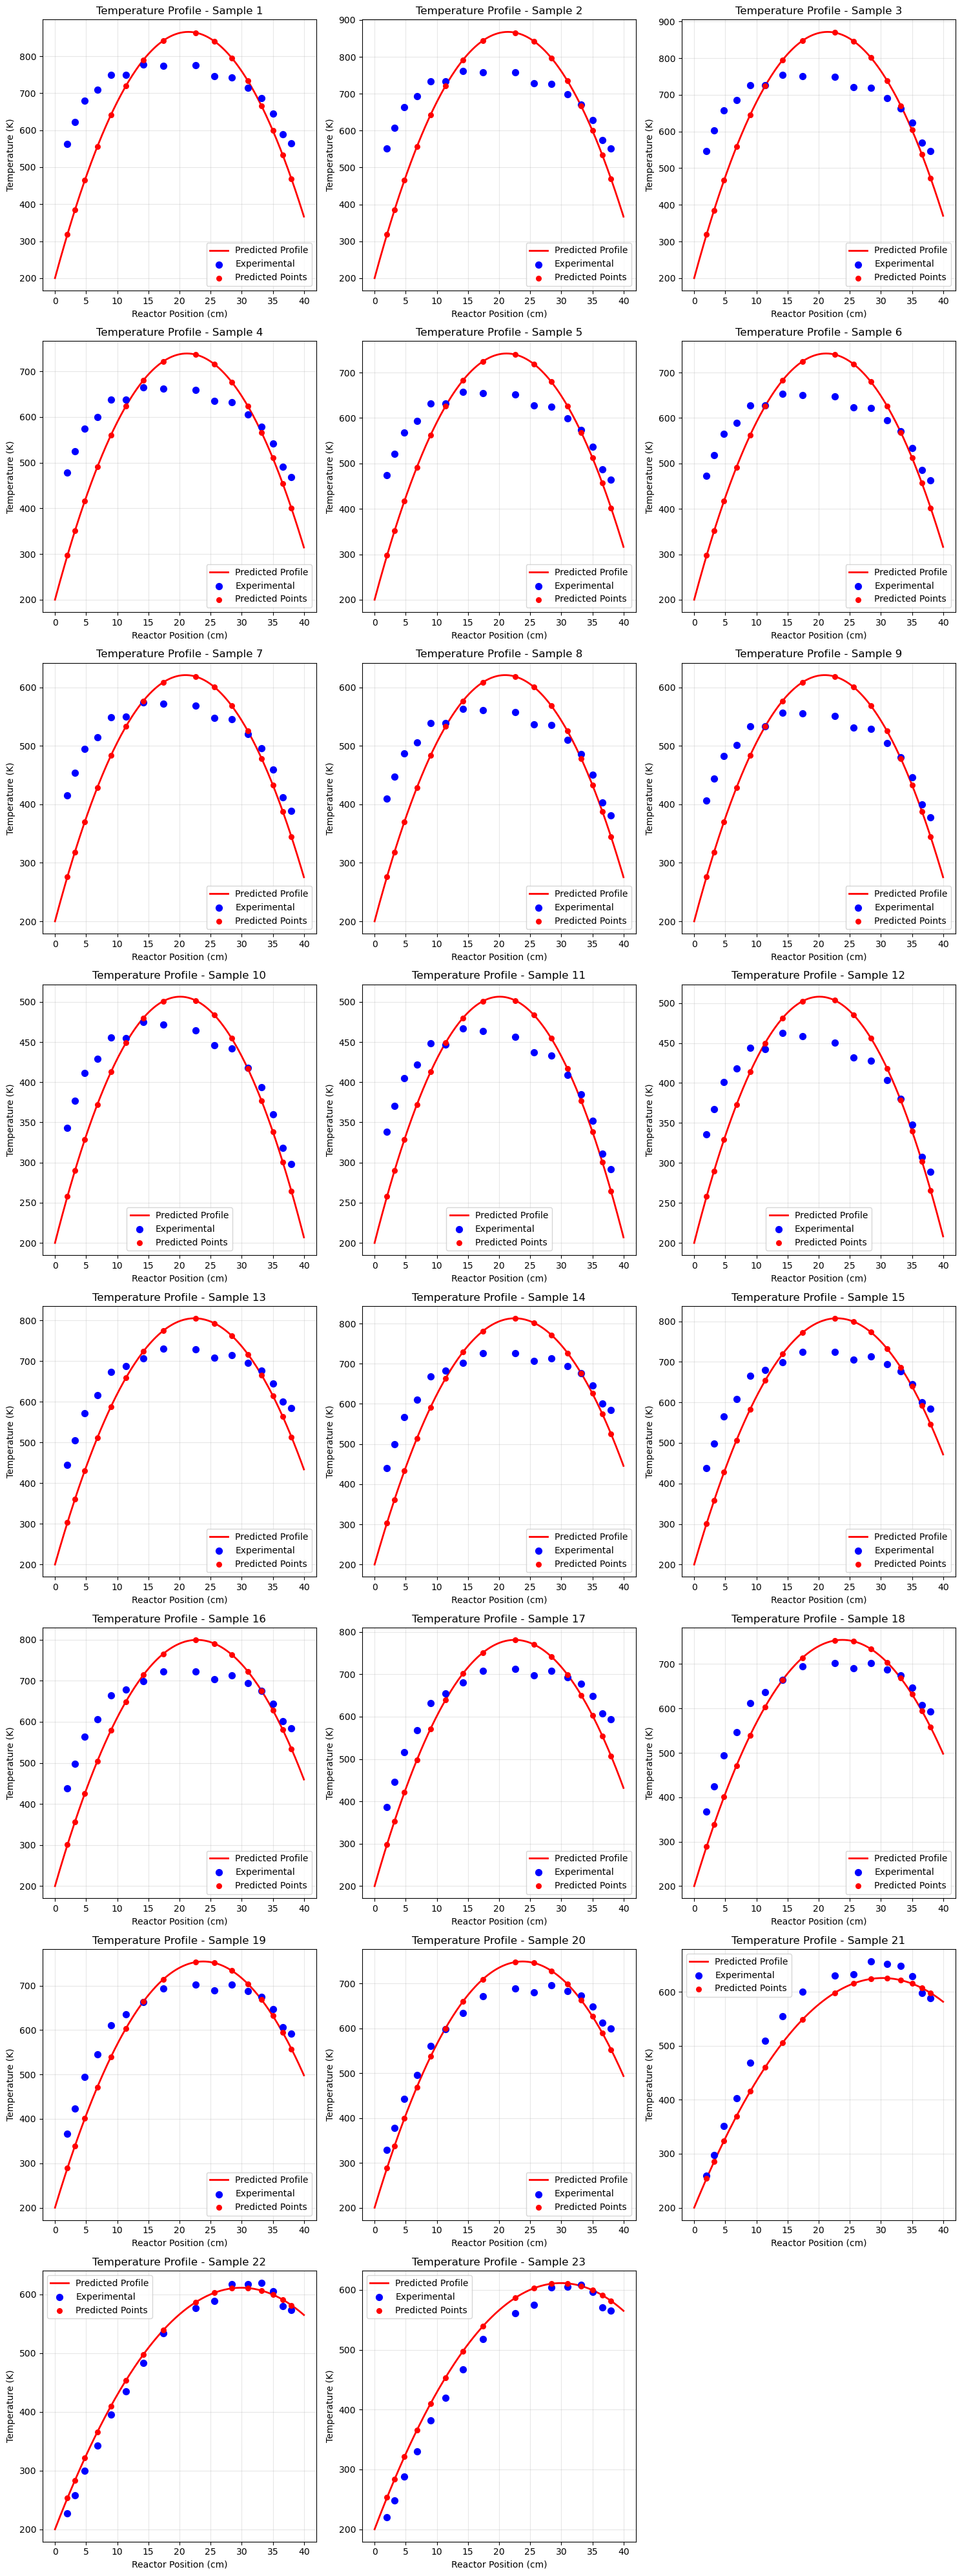

In [78]:
import matplotlib.pyplot as plt

def evaluate_model(model, data, temp_indices):
    """모델 평가 및 시각화"""
    model.eval()
    
    # 데이터 수에 따라 subplot 배치 결정
    n_samples = len(data)
    cols = 3  # 한 행에 3개씩
    rows = (n_samples + cols - 1) // cols
    
    # 조성 비교 플롯
    fig1, axes1 = plt.subplots(rows, cols, figsize=(15, 5*rows))
    if n_samples == 1:
        axes1 = [axes1]
    else:
        axes1 = axes1.flatten()
    
    # 온도 프로파일 플롯
    fig2, axes2 = plt.subplots(rows, cols, figsize=(15, 5*rows))
    if n_samples == 1:
        axes2 = [axes2]
    else:
        axes2 = axes2.flatten()
    
    component_names = ['CO2', 'H2', 'Ar', 'CO', 'CH4', 'H2O']
    
    with torch.no_grad():
        for i in range(n_samples):
            row = data.iloc[i]
            
            # 입력: Flow, Power
            flow_power = torch.tensor([row['Flow'], row['Power']], dtype=torch.float32)
            
            # 예측
            pred = model(flow_power)  # (201, 7)
            
            # 1. 조성 비교 (subplot 1)
            ax1 = axes1[i]
            
            # 실험 데이터 조성
            exp_composition = [row['CO2'], row['H2'], row['Ar'], row['CO'], row['CH4'], row['H2O']]
            # 예측 조성 (출구)
            pred_composition = pred[-1, :6].numpy()
            
            x_pos = range(len(component_names))
            width = 0.35
            
            ax1.bar([x - width/2 for x in x_pos], exp_composition, width, 
                   label='Experimental', alpha=0.7, color='blue')
            ax1.bar([x + width/2 for x in x_pos], pred_composition, width,
                   label='Predicted', alpha=0.7, color='red')
            
            ax1.set_xlabel('Components')
            ax1.set_ylabel('Mole Fraction')
            ax1.set_title(f'Composition Comparison - Sample {i+1}\nFlow: {row["Flow"]:.1f} L/min, Power: {row["Power"]:.1f} W')
            ax1.set_xticks(x_pos)
            ax1.set_xticklabels(component_names)
            ax1.legend()
            ax1.grid(True, alpha=0.3)
            
            # 2. 온도 프로파일 비교 (subplot 2)
            ax2 = axes2[i]
            
            # 실험 온도 데이터
            exp_temps = [row[f'TI-{j}'] for j in range(1, 17)]
            # 예측 온도 (16개 측정점)
            pred_temps = pred[temp_indices, 6].numpy()
            # 전체 온도 프로파일
            z_full = torch.linspace(0, 40, 201).numpy()
            temp_full = pred[:, 6].numpy()
            
            # 측정점 위치 계산
            z_measure = z_full[temp_indices]
            
            ax2.plot(z_full, temp_full, 'r-', linewidth=2, label='Predicted Profile')
            ax2.scatter(z_measure, exp_temps, c='blue', s=50, label='Experimental', zorder=5)
            ax2.scatter(z_measure, pred_temps, c='red', s=30, label='Predicted Points', zorder=5)
            
            ax2.set_xlabel('Reactor Position (cm)')
            ax2.set_ylabel('Temperature (K)')
            ax2.set_title(f'Temperature Profile - Sample {i+1}')
            ax2.legend()
            ax2.grid(True, alpha=0.3)
            
            # 오차 계산 및 출력
            composition_mae = np.mean(np.abs(np.array(exp_composition) - pred_composition))
            temp_mae = np.mean(np.abs(np.array(exp_temps) - pred_temps))
            
            print(f"Sample {i+1} - Composition MAE: {composition_mae:.4f}, Temperature MAE: {temp_mae:.2f} K")
    
    # 빈 subplot 제거
    for i in range(n_samples, len(axes1)):
        fig1.delaxes(axes1[i])
        fig2.delaxes(axes2[i])
    
    plt.tight_layout()
    plt.show()
    
    return fig1, fig2

# 학습 후 평가
print("\n=== 모델 평가 결과 ===")
fig1, fig2 = evaluate_model(hybrid_model, df_full, temp_indices)